In [329]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt
import math
import os, sys
sys.path.append("../src")

from sentences_selection import select_sentences
import copy

In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-25 23:04:28 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [38]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [39]:
import re
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def sentences_splitting(text, rdrsegmenter=rdrsegmenter):

    text_lower = no_accent_vietnamese(text.lower())
    
    original_sents=[]
    processed_sents = []
    
    text_pos = 0
    for _, sent in rdrsegmenter.annotate_text(text).items():
        words = [w["wordForm"] for w in sent]
        words = [w.replace("_", " ") if w != "_" else "_" for w in words]

        processed_sents.append(" ".join(words))

        words = [no_accent_vietnamese(w.lower()) for w in words]
        words = sum([w.split() for w in words],[])


        # find position of words in text_lower
        pos_start = []
        pos_end = []

        for w in words:
            idx = text_lower.find(w,text_pos)

            pos_start.append(idx)
            pos_end.append(idx + len(w))

            text_pos = idx + len(w)
        
        # for testing
        # test = [text_lower[pos_start[i]: pos_end[i]] for i in range(len(pos_start))]
        # assert test == words

        original_sents.append(text[pos_start[0]: pos_end[-1]])
    return original_sents, processed_sents


In [40]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [41]:
idx = 29706

In [42]:
data.sample(n=1).reset_index().loc[0]

index                                                  41171
context    Các khu vui chơi giải trí Sun World của Sun Gr...
claim                             Mỗi nhánh của cầu dài 400m
Name: 0, dtype: object

In [2695]:
idx = 29706
sample = data.sample(n=1).reset_index().loc[0]
text = sample["context"]
claim = sample["claim"]
context = rdrsegmenter.word_segment(text)

In [2696]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [2697]:
query = no_accent_vietnamese(clean_str(claim)).split()
query

['alisa',
 'cho',
 'biet',
 'sau',
 'khi',
 'tot',
 'nghiep',
 'thi',
 'se',
 'qua',
 'my',
 'de',
 'hoc',
 'tiep']

In [2698]:
[no_accent_vietnamese(clean_str(doc)) for doc in context]

['tu khi duoc biet toi la   than dong     alisa cham soi guong va luon chon quan ao dep moi khi ra duong  ',
 'nguoi giam ho cua hai be lam viec trong linh vuc tai chinh   khong chia se ky ve danh tinh cung nhu cuoc song rieng  ',
 'chi cho biet gap vicky tu khi con chua phat lo kha nang dac biet  ',
 'khi vicky noi tieng   chi duoc nhieu nguoi hoi ve cach chon loc de nhan duoc nhung nguoi con nuoi tai nang  ',
 '  nhieu nguoi hieu sai co duyen cua hai me con   nghi rang toi nhan con nuoi co muc dich   tinh toan     nguoi me giai thich ly do an danh   de tranh gap nhung cau hoi gay ton thuong voi ba me con  ',
 'khong biet tieng anh nen nhung tuan dau   hai chi em choi voi nhau vi khong co ban  ',
 'thay cac con chua the hoa nhap   nguoi me goi y   nam cau hoi than ky   de lam quen  ',
 '  me day nam cau hoi ve y nghia cai ten   mon an yeu thich   ban den tu vung dat nao   choi mon the thao gi va thich cuon sach nao nhat  ',
 'tuy nhien moi ap dung hai cau dau   em da quen duoc ca lop 

In [2699]:
bm25 = BM25Okapi([no_accent_vietnamese(clean_str(doc)).split() for doc in context])

In [2700]:
query_score = bm25.get_scores(query=query)
query_score

array([ 4.01457659,  2.09177434,  6.82213241,  2.59209919,  0.80751439,
        2.02772021,  1.20712462,  0.        ,  0.        ,  0.0749829 ,
        0.        ,  3.72734326,  4.62581032,  2.49367523,  0.7752914 ,
        2.09675026,  0.06324182,  0.78084564,  0.0734674 ,  2.28113203,
        2.4522698 ,  2.106421  ,  0.52652758,  1.89675822,  0.10245894,
        1.73941295,  0.09965011,  1.74300442,  2.06010299,  2.85286699,
        2.96843981,  1.84558959,  0.85996395,  1.75191983,  5.97280143,
        4.83961181,  0.75962178,  1.59615513,  2.52607543, 13.61429167,
        0.09207741,  2.78009484,  0.71505887,  3.82185888,  2.59851513,
        1.90223566,  4.17354051,  2.04481483,  2.61150792,  2.13311147,
        0.09447043,  2.92898939,  2.49342279,  0.        ])

In [2701]:
def distribute_score(score, arr_len, pos):
    if arr_len == 1:
        return [score]
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/(arr_len - 1)
    my_std = 0.65 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [2702]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

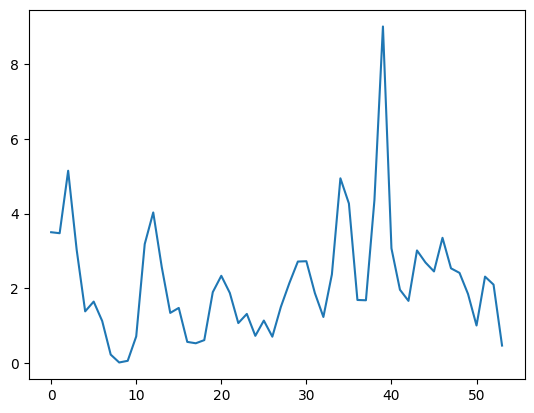

In [2703]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [2704]:
claim

'alisa cho biết, sau khi tốt nghiệp thì sẽ qua mỹ để học tiếp'

In [2705]:
[context[i] for i in sorted_ids]

['Cô bé sẽ trở_thành nhà_nghiên_cứu trẻ nhất New_Zealand sau khi tốt_nghiệp và Alisa cũng vậy " , thầy Codling chia_sẻ .',
 'Chị cho biết gặp Vicky từ khi con chưa phát_lộ khả_năng đặc_biệt .',
 'Nếu có biểu_hiện căng_thẳng hay quá_tải , Alisa sẽ được dừng lại .',
 '" Tôi tự_hào khi chứng_kiến Vicky hoàn_thành đại_học , cao_học và giờ chuẩn_bị bậc tiến_sĩ .',
 'Người mẹ cho biết thêm , khi nhận Alisa vào học , từ đầu năm , trường đã bàn_bạc với giáo_viên bộ_môn , dựng lại ví_dụ trong bài_học , tránh ảnh_hưởng đến tâm_lý của bé .',
 'Khi đã thu_hút được sự chú_ý , hai chị_em tiếp_tục câu thứ hai về món ăn yêu thích .',
 'Từ khi được biết tới là " thần_đồng " , Alisa chăm soi gương và luôn chọn quần_áo đẹp mỗi khi ra đường .',
 'Người giám_hộ của hai bé làm_việc trong lĩnh_vực tài_chính , không chia_sẻ kỹ về danh_tính cũng như cuộc_sống riêng .',
 '" Tôi chấp_nhận việc các con đánh mất thẻ , chuyển nhầm tiền ... nhưng bằng cách này , các bé biết lên kế_hoạch , trở_nên độc_lập , trưởng_th

In [2706]:
model_max_length = 256
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [2707]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

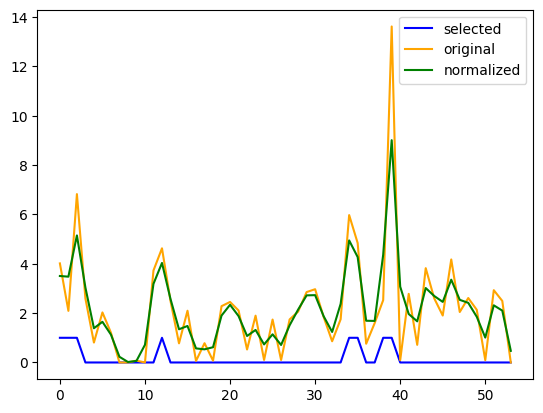

In [2708]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [2709]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Từ khi được biết tới là " thần_đồng " , Alisa chăm soi gương và luôn chọn quần_áo đẹp mỗi khi ra đường .',
 'Người giám_hộ của hai bé làm_việc trong lĩnh_vực tài_chính , không chia_sẻ kỹ về danh_tính cũng như cuộc_sống riêng .',
 'Chị cho biết gặp Vicky từ khi con chưa phát_lộ khả_năng đặc_biệt .',
 'Khi đã thu_hút được sự chú_ý , hai chị_em tiếp_tục câu thứ hai về món ăn yêu thích .',
 'Nếu có biểu_hiện căng_thẳng hay quá_tải , Alisa sẽ được dừng lại .',
 'Người mẹ cho biết thêm , khi nhận Alisa vào học , từ đầu năm , trường đã bàn_bạc với giáo_viên bộ_môn , dựng lại ví_dụ trong bài_học , tránh ảnh_hưởng đến tâm_lý của bé .',
 '" Tôi tự_hào khi chứng_kiến Vicky hoàn_thành đại_học , cao_học và giờ chuẩn_bị bậc tiến_sĩ .',
 'Cô bé sẽ trở_thành nhà_nghiên_cứu trẻ nhất New_Zealand sau khi tốt_nghiệp và Alisa cũng vậy " , thầy Codling chia_sẻ .']

In [2710]:
claim

'alisa cho biết, sau khi tốt nghiệp thì sẽ qua mỹ để học tiếp'

# context slicing
slice a single context into multiple smaller context 

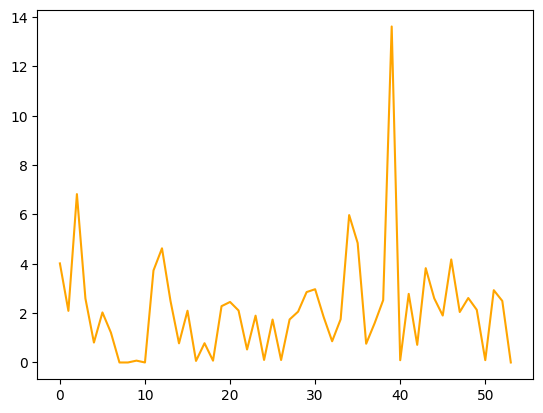

In [2711]:
plt.plot(x, query_score,color="orange",label="original")
plt.show()

In [2712]:
context_tk_length


[26,
 21,
 15,
 22,
 40,
 20,
 19,
 34,
 26,
 26,
 19,
 20,
 20,
 20,
 20,
 71,
 33,
 19,
 25,
 13,
 23,
 23,
 32,
 21,
 9,
 16,
 11,
 19,
 19,
 12,
 21,
 31,
 13,
 26,
 15,
 38,
 24,
 24,
 18,
 25,
 13,
 8,
 17,
 28,
 32,
 26,
 63,
 35,
 25,
 36,
 11,
 11,
 18,
 2]

In [2713]:
def get_longest_continuest_context(tokenized_sents_lenght, start_pos, max_token_number):
    if start_pos >= len(tokenized_sents_lenght):
        return [], 0
    selected = []
    curr_length = 0
    for idx in range(start_pos, len(tokenized_sents_lenght)):
        if curr_length + tokenized_sents_lenght[idx] > max_token_number:
            break
        selected.append(idx)
        curr_length += tokenized_sents_lenght[idx]
    
    return selected, curr_length

In [2714]:
def get_best_continuest_context(tokenized_sents_lenght, query_score, max_token_number=200):
    best_context = []
    max_score = 0
    for i in range(len(tokenized_sents_lenght)):
        selected, curr_length = get_longest_continuest_context(tokenized_sents_lenght, start_pos=i, max_token_number=max_token_number)
        score = sum([query_score[i] for i in selected])
        if score > max_score:
            best_context = selected
            max_score = score
    return best_context, max_score

In [2715]:
best_context, max_score = get_best_continuest_context(
    tokenized_sents_lenght=context_tk_length,
    query_score=query_score
)

print([context[i] for i in best_context])

['Hàng tuần , Alisa có ba buổi gặp giáo_viên tâm_lý để đánh_giá xem liệu em có thích_nghi được với việc học hay không .', 'Nếu có biểu_hiện căng_thẳng hay quá_tải , Alisa sẽ được dừng lại .', 'Người mẹ cho biết thêm , khi nhận Alisa vào học , từ đầu năm , trường đã bàn_bạc với giáo_viên bộ_môn , dựng lại ví_dụ trong bài_học , tránh ảnh_hưởng đến tâm_lý của bé .', '" Giáo_trình học của Alisa không có ví_dụ về bạo_lực hay tình_dục " , người giám_hộ của cô bé nói .', 'Thầy Andrew_Codling , trưởng Văn_phòng Hiệu_trưởng AUT , bày_tỏ hạnh_phúc khi đồng_hành với Alisa và Vicky .', '" Tôi tự_hào khi chứng_kiến Vicky hoàn_thành đại_học , cao_học và giờ chuẩn_bị bậc tiến_sĩ .', 'Cô bé sẽ trở_thành nhà_nghiên_cứu trẻ nhất New_Zealand sau khi tốt_nghiệp và Alisa cũng vậy " , thầy Codling chia_sẻ .', 'Lớp của Alisa có 60-70 sinh_viên , tuổi trung_bình 23 .', 'Alisa đặc_biệt thích môn Thiết_kế .']


In [2716]:
def slice_context(tokenized_sents_lenght, number_of_contexts, query_score, max_token_number=200):
    qscores = copy.copy(query_score)
    selected = []

    for _ in range(number_of_contexts*2):
        if len(selected) >= number_of_contexts:
            break
        best_context, max_score = get_best_continuest_context(
            tokenized_sents_lenght=context_tk_length,
            query_score=qscores,
            max_token_number=max_token_number
        )
        
        # reduce the score of the selected context

        for i in best_context:
            qscores[i] /= 3.5
        print(max_score)
        if best_context not in selected:
            selected.append(best_context)
    return selected

In [2717]:
MODEL_MAX_TOKEN = 500

In [2718]:
math.ceil(sum(context_tk_length)*1.25/MODEL_MAX_TOKEN)

4

In [2719]:
res = slice_context(
    tokenized_sents_lenght=context_tk_length,
    number_of_contexts = math.ceil(sum(context_tk_length)*1.2/MODEL_MAX_TOKEN),
    query_score=query_score,
    max_token_number=MODEL_MAX_TOKEN
)
res

62.00416546404296
34.274349979719304
31.971913008022373
10.906006777361165


[[19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53],
 [11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32]]

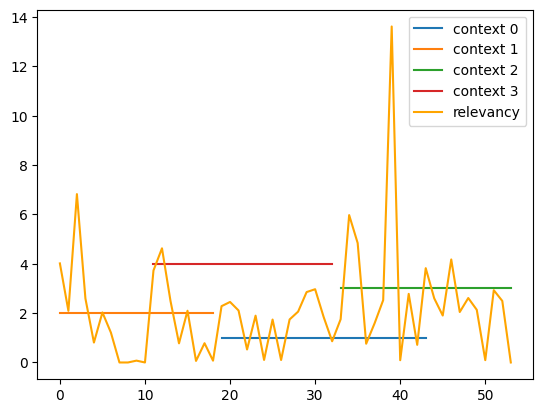

In [2720]:

for idx,sl in enumerate(res):
    plt.plot(sl, [1 + idx for _ in range(len(sl))], label="context " + str(idx))
plt.plot(x, query_score,color="orange",label="relevancy")
plt.legend(loc='best')

plt.show()


In [2721]:
sum(context_tk_length)

1254

In [2722]:
claim

'alisa cho biết, sau khi tốt nghiệp thì sẽ qua mỹ để học tiếp'

In [2723]:
[[context[i] for i in sl] for sl in res]

[['Em chỉ mất bốn năm để từ lớp hai vào đại_học .',
  'Alisa giải_thích , em học vượt_cấp dễ_dàng vì chương_trình của New_Zealand có tính ứng_dụng và đề_cao sự sáng_tạo của học_sinh .',
  '" Em cũng muốn tiết_kiệm tiền , bằng cách học vượt , để mẹ đỡ vất_vả " , Alisa nói .',
  'Theo người giám_hộ của hai bé , trong hệ_thống giáo_dục New_Zealand , nếu muốn học vượt_cấp , các em cần được xem_xét cụ_thể và được sự đồng_ý của Bộ_trưởng Giáo_dục .',
  'Trong vòng hai năm , người mẹ đã viết hơn 1.000 email đấu_tranh để hai con được học vượt .',
  'Alisa cũng phải hoàn_thành 80 tín_chỉ .',
  'Trong khi đó , tháng 8-11/2021 , Auckland bị phong_toả vì dịch_bệnh .',
  'Thời_điểm ấy , Alisa mới xong 21 tín_chỉ .',
  'Đầu tháng 11 , khi quay lại trường , Alisa đã hoàn_thành số tín_chỉ còn thiếu .',
  'Thông_thường , học_sinh có ba năm để hoàn_thành 60 tín_chỉ , Alisa chỉ mất bốn tuần .',
  'Như_thế , em phải làm sáu bài kiểm_tra mỗi tuần .',
  '" Thầy_cô đều nói_chuyện này quá khó nhưng em vẫn kiê